In [1]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = False

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

2023-03-07 14:09:32.896768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

print('traintestsplit')
df,throwaway = train_test_split(df,test_size=0.9)
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 2921 validated image filenames belonging to 8 classes.
Found 1461 validated image filenames belonging to 8 classes.
Found 2921 validated image filenames belonging to 8 classes.


In [3]:
print(df)

                                filename class
23509  ESP_034268_1795_RED-0071-r270.jpg     0
33098  ESP_026334_1755_RED-0030-r180.jpg     0
53443    ESP_025050_1680_RED-0135-fv.jpg     0
38864       ESP_036804_2345_RED-0629.jpg     0
10082  PSP_005457_2030_RED-0010-r180.jpg     1
...                                  ...   ...
59585   ESP_016781_2055_RED-0093-r90.jpg     3
49676    ESP_030082_1615_RED-0533-fh.jpg     0
21957    PSP_006766_1850_RED-0068-fv.jpg     0
51192   ESP_028733_1370_RED-1084-r90.jpg     0
61144   PSP_004673_0935_RED-0144-brt.jpg     6

[7303 rows x 2 columns]


2023-03-07 14:09:46.442027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 14:09:46.442974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-07 14:09:46.468817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-07 14:09:46.468857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen 

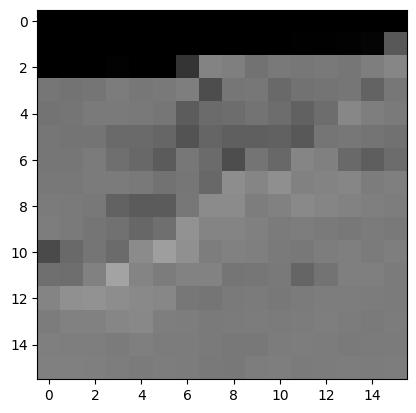

In [4]:
resize = 16
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])

plt.imshow(image_test)

In [5]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(8, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

#model.add(keras.layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2)))
#model.add(keras.layers.Dropout(0.25))

#model.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2)))
#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

#model.add(keras.layers.Dense(16, activation='relu'))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (0, 16, 16, 3)            0         
                                                                 
 conv2d (Conv2D)             (0, 16, 16, 8)            224       
                                                                 
 max_pooling2d (MaxPooling2D  (0, 8, 8, 8)             0         
 )                                                               
                                       

In [6]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
loss, acc = model.evaluate(test_ds)

12/12 [==============================] - 7s 569ms/step - loss: 0.7430 - accuracy: 0.8303


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.7346798777580261, 0.8366997838020325, 0.8366997838020325, 0.8366997838020325, 0.8366997838020325]
  accuracy (test)  =  [0.8295104503631592, 0.8295104503631592, 0.8295104503631592, 0.8295104503631592, 0.8295104503631592]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [1.176698088645935, 0.8058645129203796, 0.7803996205329895, 0.7571974992752075, 0.7307692170143127]


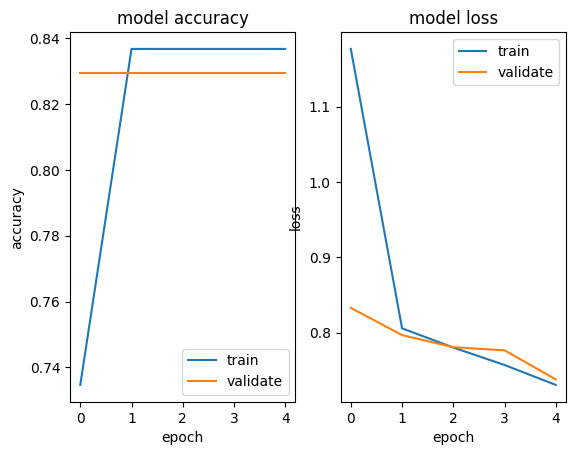

In [7]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [8]:
predictions = model.predict(test_ds)

12/12 [==============================] - 6s 490ms/step


In [9]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [10]:
print(data_dict[4])

bright dune


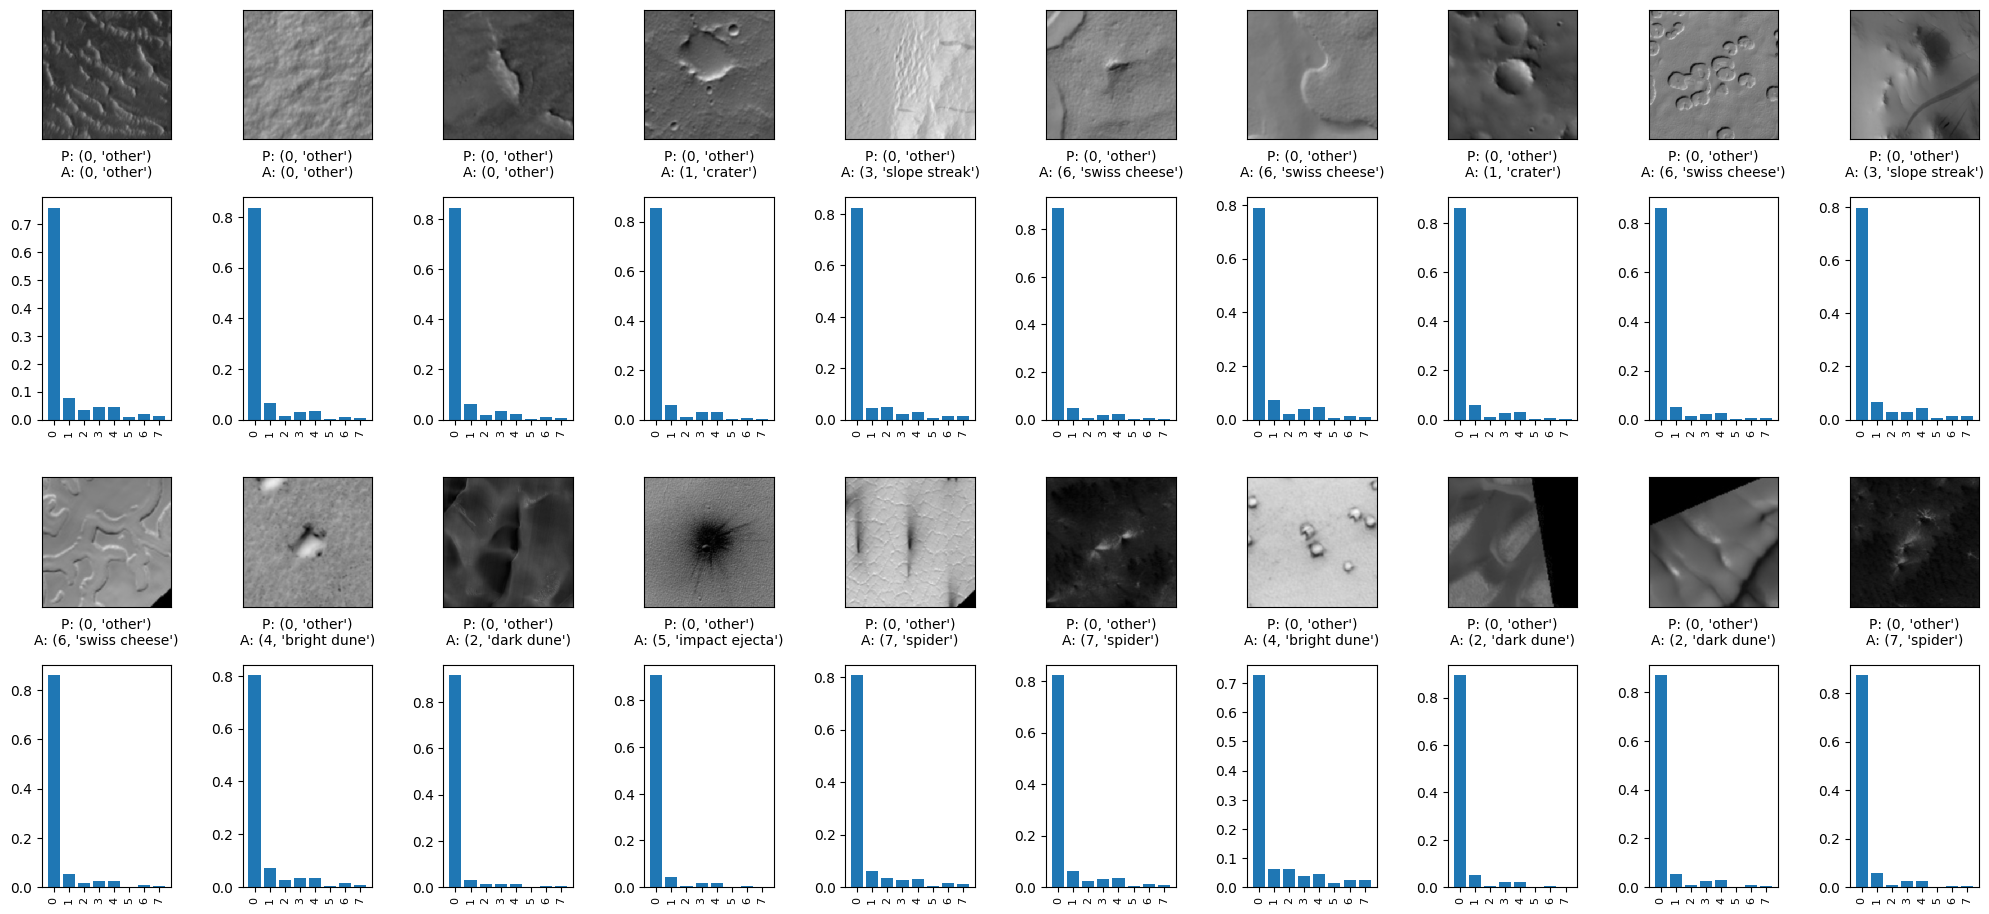

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 12))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,8,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [12]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)
print(len(abs_predictions))

1461


[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Text(0, 0.5, 'prediction accuracy')

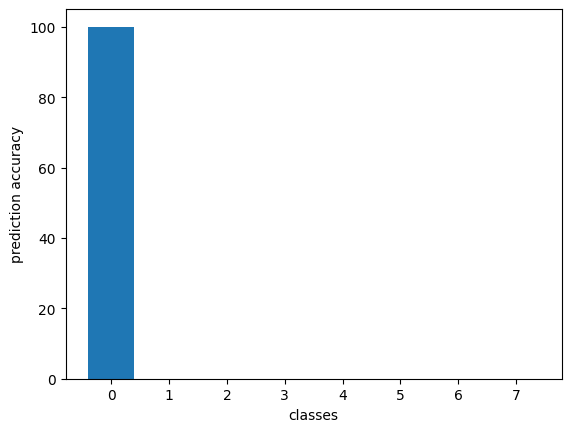

In [13]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    df_0 = test_df.loc[test_df['class'] == i]
    num_identical = sum(df_0['class'] == df_0['models class'])
    num_rows = len(df_0)
    percent_identical = num_identical / num_rows * 100
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.xlabel('classes')
plt.ylabel('prediction accuracy')

### changing to is/is not:[dune]

In [67]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df['class'] = df['class'].astype(str)

print('traintestsplit')
df,throwaway = train_test_split(df,test_size=0.9)
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize= 128
resize = 64
# and now the classes have to be strings again... whhhhhhhhhhhhhhhhhhyyyyyyyyyyyyyyyy
print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 2921 validated image filenames belonging to 3 classes.
Found 1461 validated image filenames belonging to 3 classes.
Found 2921 validated image filenames belonging to 3 classes.


In [15]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(8, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(63, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?

## HOW CAN IT TEST FOR LOSS WITHOUT A THRESHOLD IS IT SENTIENT???

model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (0, 64, 64, 3)            0         
                                                                 
 conv2d_1 (Conv2D)           (0, 64, 64, 8)            224       
                                                                 
 max_pooling2d_1 (MaxPooling  (0, 32, 32, 8)           0         
 2D)                                                             
                                     

history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264]
  accuracy (test)  =  [0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [0.6570660471916199, 0.6394146084785461, 0.6371203660964966, 0.6366647481918335, 0.6365949511528015]


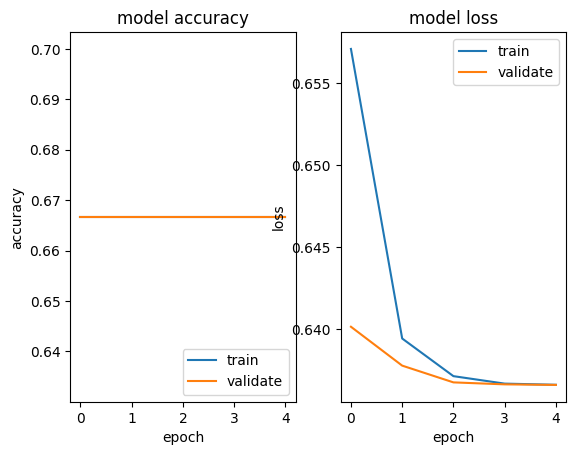

In [16]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [17]:
predictions = model.predict(test_ds)

12/12 [==============================] - 6s 529ms/step


In [37]:
print(predictions)

[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


In [83]:
#predictions = np.where(predictions >= np.mean(predictions), 1, 0)
predictions = np.where(predictions >=0.3, 1, 0)

In [84]:
for i in predictions:
    if i != 0 and i != 1:
        print(i)

In [41]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap_DUNES.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [76]:
ogawoga = test_df['class'].astype(bool)
my_classlist = ogawoga.to_numpy()

In [77]:
for i in my_classlist:
    if i == 0:
        print(i)

In [79]:
arr = np.array([bool(num) for subarr in predictions for num in subarr])

In [80]:
test = 5
print(type(my_classlist[test]))
print(type(arr[test]))

<class 'numpy.bool_'>
<class 'numpy.bool_'>


In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(my_classlist, arr)
auc_keras = auc(fpr_keras, tpr_keras)

/usr/local/anaconda3/envs/tf2.11/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


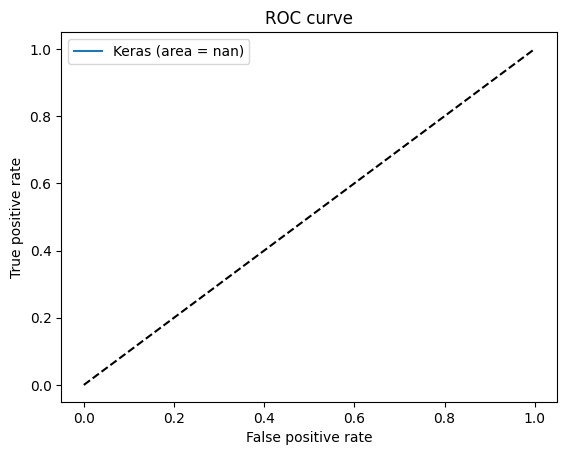

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()